In [1]:
import re

import pandas as pd
import nltk

In [2]:
comments = pd.read_csv('comments_.csv')

## Sample sentiment analysis
1. Data cleaning
2. Data prepping (OPTIONAL)
3. Data exploration
4. Prebuilt packages - Vader and Textblob

### __1.__ __Data cleaning__

 - Remove urls

In [71]:
sample = comments.Reply.iloc[10]
sample

'[Mermaid Man](http://www.runsilly.com/wp-content/uploads/2014/10/Mermaid_Man_Boatmobile.jpg) had this figured out years ago. '

In [72]:
re.sub(r'\(?http\S+', '', sample)

'[Mermaid Man] had this figured out years ago. '

 - Getting rid of \n, \t... etc characters that does not help with prediction but might link 2 words together and make them indistinguishable from one another

In [46]:
sample = comments.Reply.iloc[9]
sample

'"How about a pilot without the plane?"\n\nIron-Man, confirmed.'

In [49]:
word_tokenized = nltk.word_tokenize(sample)
word_tokenized

['``',
 'How',
 'about',
 'a',
 'pilot',
 'without',
 'the',
 'plane',
 '?',
 "''",
 'Iron-Man',
 ',',
 'confirmed',
 '.']

In [50]:
' '.join(word_tokenized)

"`` How about a pilot without the plane ? '' Iron-Man , confirmed ."

### __2.__ __Data prepping (optional)__

These steps are commonly done before you train your own model. But as we are using pre built packages (rather than building our own) these steps are not necessary - but you might as well learn about them!

 - Remove stopwords

In [37]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [42]:
sample = comments.Reply.iloc[0]
sample

'All we need now is humanless bodies'

In [52]:
stopwords_removed = [word for word in nltk.word_tokenize(comments.Reply.iloc[0]) if word.lower() not in stopwords]
' '.join(stopwords_removed)

'need humanless bodies'

 - Stemming and Lemmatization

In [53]:
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

In [54]:
text = nltk.word_tokenize('women run running runs ran')
stemmed = [porter_stemmer.stem(word) for word in text]
stemmed

['women', 'run', 'run', 'run', 'ran']

In [56]:
lemmatizer = nltk.WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word) for word in text]
lemmatized

['woman', 'run', 'running', 'run', 'ran']

- POS (Part-of-speech) and lemmatization

Just like word tokenization there is also sentence tokenization. Sentence tokenization is required if you use POS and lemmatization. This is because whether a word is a verb, adjective... depends on its place in a sentence

In [63]:
sample = comments.Reply.iloc[61]
sample

'Did a double-take. Thought it might have been April 1'

In [64]:
sentences = nltk.tokenize.sent_tokenize(sample)
sentences

['Did a double-take.', 'Thought it might have been April 1']

In [65]:
tokens = [nltk.word_tokenize(sentence) for sentence in sentences] 
tokens

[['Did', 'a', 'double-take', '.'],
 ['Thought', 'it', 'might', 'have', 'been', 'April', '1']]

In [66]:
pos_tagged_tokens = [nltk.pos_tag(token) for token in tokens] 
pos_tagged_tokens

[[('Did', 'VB'), ('a', 'DT'), ('double-take', 'NN'), ('.', '.')],
 [('Thought', 'NNP'),
  ('it', 'PRP'),
  ('might', 'MD'),
  ('have', 'VB'),
  ('been', 'VBN'),
  ('April', 'NNP'),
  ('1', 'CD')]]

Defining a function to map the POS tag to a POS value which the lemmatizer can use

In [78]:
from nltk.corpus import wordnet
def get_wordnet_pos(tag):
    
    if tag == '':
        return
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

Lemmatizing our comment from before, using our POS tags we created

In [79]:
[lemmatizer.lemmatize(x[0], get_wordnet_pos(x[1])) for x in [item for sublist in pos_tagged_tokens for item in sublist]]

['Did',
 'a',
 'double-take',
 '.',
 'Thought',
 'it',
 'might',
 'have',
 'be',
 'April',
 '1']

### __3.__ __Data exploration__

 - Bigrams

In [82]:
sample = ['more', 'is', 'said', 'than', 'done', 'is', 'said', 'than']

In [83]:
from nltk.collocations import *

bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(sample)

# only bigrams that appear 2+ times
finder.apply_freq_filter(2) 

# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.pmi, 10) )

[('is', 'said'), ('said', 'than')]


Let's try it on first 1000 rows of our text

In [92]:
all_text = comments.iloc[:1000,:].Reply.str.cat(sep='. ')

In [93]:
all_text = nltk.word_tokenize(all_text)

In [95]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(all_text)
finder.apply_freq_filter(3) 
list_of_common_bigrams = finder.nbest(bigram_measures.pmi, 10)
print (list_of_common_bigrams)

[('Dodge', 'Demon'), ('PR', 'team'), ('pissing', 'match'), ('180k', 'Turbo'), ('Marcus', 'Miles'), ('public', 'enemy'), ('Agera', 'RS'), ('South', 'Africa'), ('differences', 'lie'), ('flame', 'throwers')]


 - Wordcloud

In [107]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sample = comments.iloc[:1000,:].Reply.str.cat(sep='. ')

In [108]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

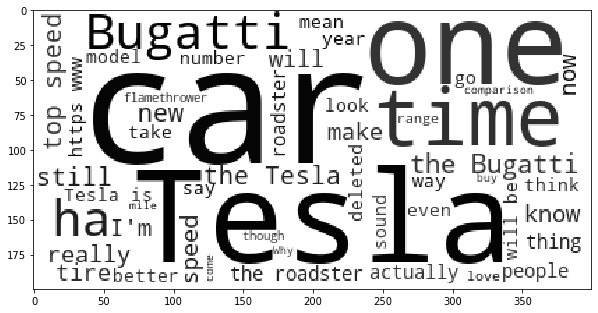

In [109]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

### 4. Using the prebuilt packages

- Vader package first

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants

#FIRST, we initialize VADER so we can use it within our Python script
sid = SentimentIntensityAnalyzer()

We can add sentiment scores to words manually if we want

In [140]:
new_words = {
    'hello': -1000,
}

sid.lexicon.update(new_words)

In [142]:
sid.polarity_scores('hello')

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -1.0}

In [13]:
#As this is for demonstration purposes only - we will only use comments from the first 100 keys
df = comments[comments.Key<101]
df.shape

(70157, 4)

In [14]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [15]:
df[['neg','neu','pos','compound']] = df.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [182]:
df.head(3)

,Reply,Time,Upvote,Key,Classification,positive,negative,neg,neu,pos,compound
0,All we need now is humanless bodies,2018-01-30 11:19:01,956,1,pos,0.514741,0.485259,0.000,1.000,0.000,0.0000
1,For a moment I read careless driver . Would ha...,2018-01-30 10:35:31,3985,1,pos,0.521948,0.478052,0.195,0.547,0.258,0.2023
2,Elon 's Twitter feed has been hilarious over t...,2018-01-30 11:21:32,1762,1,pos,0.738500,0.261500,0.083,0.833,0.083,0.0000


In [16]:
df.to_csv('sentiments_for_comments.csv', index=False)

- Textblob package now

In [154]:
from textblob.sentiments import NaiveBayesAnalyzer, PatternAnalyzer
from textblob import Blobber
tba = Blobber(analyzer=NaiveBayesAnalyzer())

In [155]:
tba('My life is a frictionless slide downhill').sentiment

Sentiment(classification='neg', p_pos=0.374939442175929, p_neg=0.6250605578240714)

In [162]:
#As this is for demonstration purposes only - we will only use comments from the first 100 keys
df = comments[comments.Key<101]

In [ ]:
#The cleaning steps as outlined earlier
df.Reply = df.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
df.Reply = df.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [174]:
df[['Classification','positive','negative']] = df.Reply.apply(lambda x: pd.Series({'Classification':tba(x).sentiment[0],
                                                                        'positive':tba(x).sentiment[1],
                                                                        'negative':tba(x).sentiment[2]}))

C:\Users\clear\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [175]:
df.head(3)

,Reply,Time,Upvote,Key,Classification,positive,negative
0,All we need now is humanless bodies,2018-01-30 11:19:01,956,1,pos,0.514741,0.485259
1,For a moment I read careless driver. Would hav...,2018-01-30 10:35:31,3985,1,pos,0.521948,0.478052
2,Elon's Twitter feed has been hilarious over th...,2018-01-30 11:21:32,1762,1,pos,0.738500,0.261500
